In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [2]:
from data_analysis_helper_fun import normalized_heat_maps_by_weights

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [4]:
 # relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha_001-150'
data_file_name = f'{data_set_name}.csv.tar.gz'
re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "fixed_point_coms_consistent",
                                           "n_fixed_points",
                                           "n_global_optima",
                                           "fp_full_re_state",
                                           "go_full_re_state",
                                           'n_full_re_states',
                                           'fixed_point_is_full_re_state'
                                           ],
                               evalcols = [
                                    "fp_full_re_state",
                                    "go_full_re_state"
                                   ])

In [5]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [6]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 1753906
   Number of dialectical structures: 150
   Overall number of initial commitments: 60
   Sentence-pools: [6 7 8]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [7]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'fixed_point_coms_consistent',
       'n_fixed_points', 'fixed_point_is_full_re_state', 'n_global_optima',
       'go_full_re_state', 'n_full_re_states', 'fp_full_re_state',
       'model_short_name'],
      dtype='object')

## Setup Dataframes

In [8]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point, 
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setups
"""
analyse_branches = False

grouping = ["model_name"]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [9]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity', 
                         'init_coms'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 #'n_global_optima',
                                 'go_full_re_state',
                                 #'n_full_re_states'
                                ]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_full_re_state`)
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity",
                                     ]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(1644574, 6)

In [10]:
# this corresponds to a grouping according to simulation setups

#go_data["rel_go_full_re"] = go_data["n_full_re_states"]/go_data["n_global_optima"]
#go_data.groupby("model_name")["rel_go_full_re"].describe()


In [11]:
grouped_go_data=exploded_go_data.groupby(grouping)["go_full_re_state"].agg(["sum", "size"]).reset_index()
    
grouped_go_data = grouped_go_data.rename(columns={'sum': "n_go_full_re_state",
                                                      'size': 'n_global_optima'})

In [12]:
grouped_go_data["n_global_optima"].sum()

1644574

In [13]:
# relative shares
grouped_go_data["rel_go_full_re"] = grouped_go_data["n_go_full_re_state"]/grouped_go_data["n_global_optima"]

In [14]:
grouped_go_data

,model_name,n_go_full_re_state,n_global_optima,rel_go_full_re
0,LinearGlobalRE,143101,427168,0.334999
1,LinearLocalRE,143101,427168,0.334999
2,QuadraticGlobalRE,67300,458389,0.146819
3,QuadraticLocalRE,60261,331849,0.181592


In [15]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       'fixed_point_is_full_re_state']]
    
    # rename fixed point columns 
    # note: df is already exploded
    exploded_fp_data = fp_data.rename(columns={'fixed_point_is_full_re_state': "fp_full_re_state",})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "fp_full_re_state",
                                     #"n_fixed_points"
                                    ]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `fp_full_re_state`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(922824, 6)

In [16]:
fp_data.shape

(416160, 6)

In [17]:
grouped_fp_data=exploded_fp_data.groupby(grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
    
grouped_fp_data = grouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
                                                      'size': 'n_fixed_points'})

In [18]:
#if analyse_branches:
#    
#    grouped_fp_data=fp_data.groupby(grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
#    
#    grouped_fp_data = grouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
#                                                      'size': 'n_fixed_points'})
#else:
#    
#    fp_data["n_fp_full_re_state"] = fp_data["fp_full_re_state"].map(sum)

In [19]:
#fp_data.head()

In [20]:
grouped_fp_data["n_fixed_points"].sum()

922824

In [21]:
# relative shares
grouped_fp_data["rel_fp_full_re"] = grouped_fp_data["n_fp_full_re_state"]/grouped_fp_data["n_fixed_points"]

In [22]:
grouped_fp_data

,model_name,n_fp_full_re_state,n_fixed_points,rel_fp_full_re
0,LinearGlobalRE,55536,223116,0.248911
1,LinearLocalRE,35945,160228,0.224337
2,QuadraticGlobalRE,35185,299679,0.117409
3,QuadraticLocalRE,23433,239801,0.097719


## Tables

In [23]:
#model_short_names = {'StandardGlobalReflectiveEquilibrium':'QuadraticGlobalRE',
#                     'StandardLocalReflectiveEquilibrium':'QuadraticLocalRE',
#                     'StandardGlobalReflectiveEquilibriumLinearG': 'LinearGlobalRE',
#                     'StandardLocalReflectiveEquilibriumLinearG': 'LinearLocalRE'
#                    }
#
#
## Adding model short names
#go_data['model_name'] = go_data['model_name'].map(lambda x: model_short_names[x])
#fp_data['model_name'] = fp_data['model_name'].map(lambda x: model_short_names[x])

In [24]:
#fp_data.groupby("model_name")[["rel_fp_full_re", 
#                               "n_fp_full_re_state",
#                               "n_fixed_points"]].agg({"rel_fp_full_re":"mean",
#                                                       "n_fp_full_re_state":"sum",
#                                                       "n_fixed_points":"sum"})

In [25]:
#fp_data.groupby("model_name")[["rel_fp_full_re", 
#                               "n_fp_full_re_state",
#                               "n_fixed_points"]].agg({"rel_fp_full_re":"mean",
#                                                       "n_fp_full_re_state":"sum",
#                                                       "n_fixed_points":"sum"})

In [26]:
# if not analyse_branches:
#     
#     # group by simulation setup and calculate mean over relative shares of consistency cases
#     fp_overall_results = fp_data.groupby(['model_name',
#                                                'ds',
#                                                'init_coms',
#                                                'weight_account',
#                                                'weight_systematicity'
#                                               ])["rel_fp_full_re"].mean().reset_index()
#     
#     # and then group by model_name only
#     fp_overall_results = fp_overall_results.groupby(['model_name',
#                      #'ds',
#                      #'init_coms',
#                      #'weight_account',
#                      #'weight_systematicity'
#                      ])["rel_fp_full_re"].mean().round(2).reset_index()
#     
# else:
#     fp_overall_results = fp_data[["model_name", "rel_fp_full_re"]].round(2)

In [27]:
# group by model_name only
fp_overall_results = grouped_fp_data.groupby(['model_name',
                      #'ds',
                      #'init_coms',
                      #'weight_account',
                      #'weight_systematicity'
                      ])["rel_fp_full_re"].mean().reset_index()

go_overall_results =grouped_go_data.groupby(['model_name',
                     #'ds',
                     #'init_coms',
                     #'weight_account',
                     #'weight_systematicity'
                     ])["rel_go_full_re"].mean().reset_index()

In [28]:
fp_overall_results

,model_name,rel_fp_full_re
0,LinearGlobalRE,0.248911
1,LinearLocalRE,0.224337
2,QuadraticGlobalRE,0.117409
3,QuadraticLocalRE,0.097719


In [29]:
# group by simulation setup and calculate mean over relative shares of consistency cases
#o_overall_results = go_data.groupby(['model_name',
#                                              'ds',
#                                              'init_coms',
#                                              'weight_account',
#                                              'weight_systematicity'
#                                             ])["rel_go_full_re"].mean().reset_index()

#o_overall_results = go_overall_results.groupby(['model_name',
#                    #'ds',
#                    #'init_coms',
#                    #'weight_account',
#                    #'weight_systematicity'
#                    ])["rel_go_full_re"].mean().round(2).reset_index()

In [30]:
go_overall_results

,model_name,rel_go_full_re
0,LinearGlobalRE,0.334999
1,LinearLocalRE,0.334999
2,QuadraticGlobalRE,0.146819
3,QuadraticLocalRE,0.181592


In [31]:
overall_result_df = go_overall_results.join(fp_overall_results.set_index("model_name"), on="model_name")
overall_result_df

,model_name,rel_go_full_re,rel_fp_full_re
0,LinearGlobalRE,0.334999,0.248911
1,LinearLocalRE,0.334999,0.224337
2,QuadraticGlobalRE,0.146819,0.117409
3,QuadraticLocalRE,0.181592,0.097719


In [32]:
# Changing col names for readability
cols_for_tables = {'model_name':'Model',
                   'rel_go_full_re': 'Relative share of full RE states among global optima',
                   'rel_fp_full_re': 'Relative share of full RE states among fixed_points',
                  }

display(overall_result_df.rename(columns=cols_for_tables))

,Model,Relative share of full RE states among global optima,Relative share of full RE states among fixed_points
0,LinearGlobalRE,0.334999,0.248911
1,LinearLocalRE,0.334999,0.224337
2,QuadraticGlobalRE,0.146819,0.117409
3,QuadraticLocalRE,0.181592,0.097719


In [33]:
# Export
if export_results:
    file_name = 'table_rel_full_re_go_fp_{}.csv'.format('branches' if analyse_branches else 'setups')
    overall_result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)

## Plots

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
#custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(11,8)}
#sns.set_theme(style="white", context="notebook", font_scale=1.25, rc=custom_params)



viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
sns.set_palette(sns.color_palette(viridis))

### Barplots

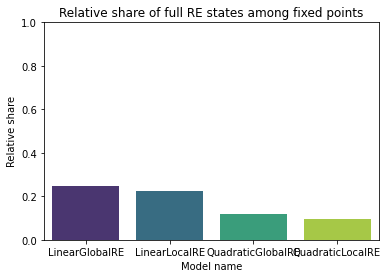

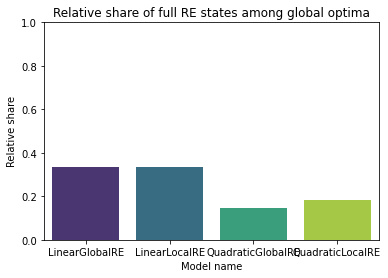

<Figure size 432x288 with 0 Axes>

In [36]:
for df, endpoint_type in zip([grouped_fp_data, grouped_go_data], ['fp', 'go']):
    
    

    ax = sns.barplot(data=df, 
                x="model_name", 
                y="rel_{}_full_re".format(endpoint_type),
                hue="model_name",
                #estimator=np.mean, 
                #errorbar="sd",
                legend=False,
                )
    ax.set(xlabel='Model name', ylabel='Relative share')
    
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
    
    ax.set(title="Relative share of full RE states among {}".format(endpoint))
    plt.ylim(0,1)
    plt.show()
    
    branches = "branches" if analyse_branches else "setups"
        
    if export_results:
        plt.savefig(path.join(figures_output_dir, 'overall_{}_full_re_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'overall_{}_full_re_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')

### Heatmaps

In [37]:
new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [38]:
wgrouped_go_data=exploded_go_data.groupby(new_grouping)["go_full_re_state"].agg(["sum", "size"]).reset_index()
    
wgrouped_go_data = wgrouped_go_data.rename(columns={'sum': "n_go_full_re_state",
                                                      'size': 'n_global_optima'})

# relative shares
wgrouped_go_data["rel_go_full_re"] = wgrouped_go_data["n_go_full_re_state"]/wgrouped_go_data["n_global_optima"]
wgrouped_go_data["rel_go_full_re"] = wgrouped_go_data["rel_go_full_re"].astype(float).round(2)

In [39]:
wgrouped_fp_data=exploded_fp_data.groupby(new_grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
    
wgrouped_fp_data = wgrouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
                                                      'size': 'n_fixed_points'})

# relative shares
wgrouped_fp_data["rel_fp_full_re"] = wgrouped_fp_data["n_fp_full_re_state"]/wgrouped_fp_data["n_fixed_points"]

wgrouped_fp_data["rel_fp_full_re"] = wgrouped_fp_data["rel_fp_full_re"].astype(float).round(2)

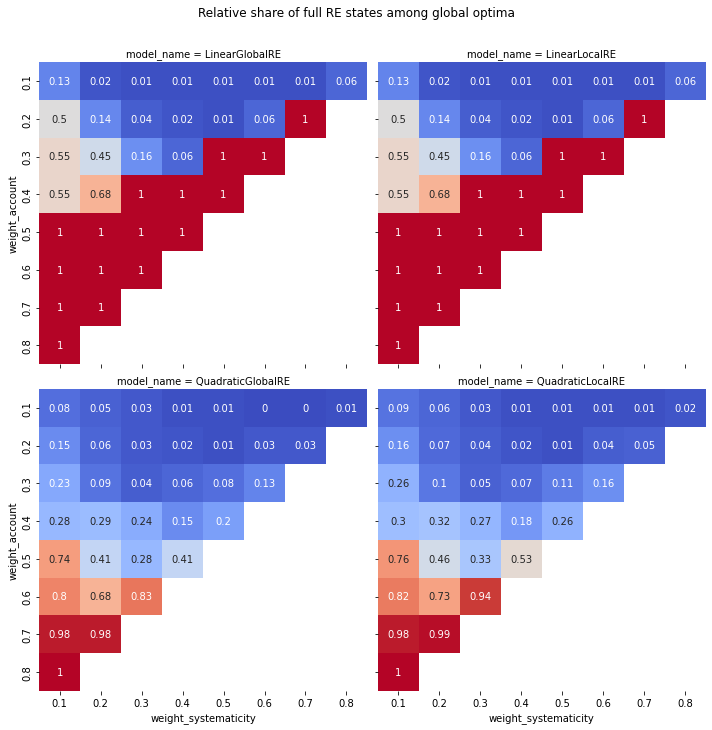

In [40]:
normalized_heat_maps_by_weights(wgrouped_go_data, 
                                "rel_go_full_re", 
                                "Relative share of full RE states among global optima",
                                annot_std = False,
                                #annot_fmt="{:2.2f}\n"
                               )
      
branches = "branches" if analyse_branches else "setups"
        
if export_results:
    plt.savefig(path.join(figures_output_dir, 'rel_go_full_re_{}.png'.format(branches)), bbox_inches='tight')
    plt.savefig(path.join(figures_output_dir, 'rel_go_full_re_{}.pdf'.format(branches)), bbox_inches='tight')

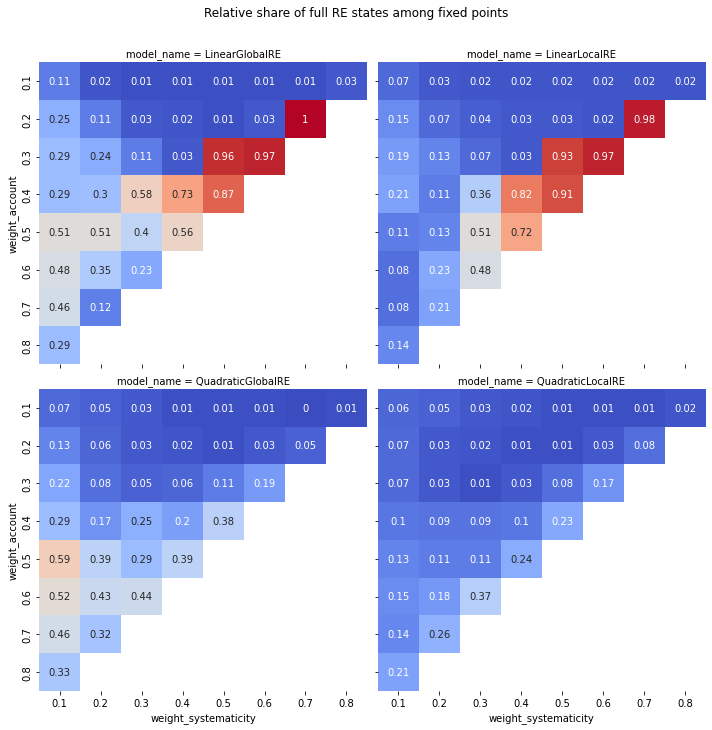

In [41]:
normalized_heat_maps_by_weights(wgrouped_fp_data, 
                                "rel_fp_full_re", 
                                "Relative share of full RE states among fixed points",
                                annot_std = False,
                                annot_fmt="{:2.2f}\n")

branches = "branches" if analyse_branches else "setups"
        
if export_results:
    plt.savefig(path.join(figures_output_dir, 'rel_fp_full_re_{}.png'.format(branches)), bbox_inches='tight')
    plt.savefig(path.join(figures_output_dir, 'rel_fp_full_re_{}.pdf'.format(branches)), bbox_inches='tight')